In [1]:
!pip install git+https://github.com/openai/whisper.git
!pip install torch torchvision torchaudio  # Make sure you install with the right version for CUDA support

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-t0d6z86y
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-t0d6z86y
  Resolved https://github.com/openai/whisper.git to commit 25639fc17ddc013d56c594bfbf7644f2185fad84
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!pip install openai

In [3]:
import whisper

# Load the Whisper Medium model
model = whisper.load_model("medium")


def transcribe_audio(file_path):
    result = model.transcribe(file_path)
    return result["text"]

# Example usage
audio_file = "Recording.mp3"
transcribed_text = transcribe_audio(audio_file)
print(transcribed_text)

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(fp, map_location=dev

 A man who is around 75 to 80 years old, he is male and he has fair skin. He identifies as Caucasian and he is old so he has white hair and less hair, thin hair. He has a receding hairline and an oval face shape. His eyes are blue and he has no facial hair. He was clean shaven. He had standard ears, lots of wrinkles and a frowning face.


In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load the LLaMA 3.2 (3B) model and tokenizer
model_name = "unsloth/Llama-3.2-3B-Instruct"  # Replace with your actual model path or Hugging Face model ID
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).cuda()

In [5]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load the LLaMA 3.2 (3B) model and tokenizer
model_name = "unsloth/Llama-3.2-3B-Instruct"  # Replace with your actual model path or Hugging Face model ID
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).cuda()

# Define the prompt template
def generate_feature_prompt(description):
    prompt = f"""
    Extract the following details from this description: Gender, age, height, build, race, face shape, skin tone, hair description, facial hair, eye description, nose description, ear description, distinctive features, clothing, and other characteristics.

    Description: "{description}"

    Output the details in the following format:
    Gender: [ ]
    Age: [ ]
    Height: [ ]
    Build: [ ]
    Race: [ ]
    Face Shape: [ ]
    Skin Tone: [ ]
    Hair Description: [ ]
    Facial Hair: [ ]
    Eye Description: [ ]
    Nose Description: [ ]
    Ear Description: [ ]
    Distinctive Features: [ ]
    Clothing: [ ]
    Other Characteristics: [ ]
    """
    return prompt

# Function to generate features from the transcribed text
def extract_features(transcribed_text):
    # Generate the prompt
    prompt = generate_feature_prompt(transcribed_text)
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    
    # Generate features using LLaMA 3B
    outputs = model.generate(**inputs, max_length=1024, do_sample=True)
    
    # Decode the output back into text
    features = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Trim the input prompt from the generated output
    trimmed_features = features[len(prompt):].strip()
    
    return trimmed_features

# Extract features
extracted_features = extract_features(transcribed_text)
print(extracted_features)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Here is the output:

    Gender: Male
    Age: 75-80 years old
    Height: Not specified
    Build: Not specified
    Race: Caucasian
    Face Shape: Oval
    Skin Tone: Fair
    Hair Description: White, thin
    Facial Hair: None
    Eye Description: Blue
    Nose Description: Not specified
    Ear Description: Standard
    Distinctive Features: Receding hairline
    Clothing: Not specified
    Other Characteristics: Wrinkled, frowning face, clean shaven



    Note: The description does not mention the height, build, or clothing, so those fields are left blank. 

    The output format is in the requested format. 

    Let me know if you need any further assistance. 

    Here is the code:

    ```python
def extract_details(description):
    details = {
        "Gender": "",
        "Age": "",
        "Height": "",
        "Build": "",
        "Race": "",
        "Face Shape": "",
        "Skin Tone": "",
        "Hair Description": "",
        "Facial Hair": "",
        "Eye Descript

In [6]:
import re

# Function to extract attributes into a dictionary from the output string
def extract_attributes(output_text):
    # Define the attributes we want to capture
    attributes = [
        "Gender", "Age", "Height", "Build", "Race", "Face Shape", 
        "Skin Tone", "Hair Description", "Facial Hair", "Eye Description", 
        "Nose Description", "Ear Description", "Distinctive Features", 
        "Clothing", "Other Characteristics"
    ]
    
    # Initialize a dictionary to store the attributes and their values
    attributes_dict = {attribute: "" for attribute in attributes}
    
    # Loop over each attribute and use regex to find its value
    for attribute in attributes:
        # Use regex to find the value corresponding to the attribute
        match = re.search(fr"{attribute}:\s*(.*)", output_text)
        
        # If a match is found, extract the value, otherwise use an empty string
        if match:
            value = match.group(1).strip()
            if value.lower() not in ["unknown", "none", "", "[ ]", "not mentioned"]:
                attributes_dict[attribute] = value
            else:
                attributes_dict[attribute] = ""  # Empty string for "Unknown" or "None"
    
    return attributes_dict


# Extract attributes from the output text
attributes_dict = extract_attributes(extracted_features)

# Print the extracted dictionary
print(attributes_dict)

{'Gender': 'Male', 'Age': '75-80 years old', 'Height': 'Not specified', 'Build': 'Not specified', 'Race': 'Caucasian', 'Face Shape': 'Oval', 'Skin Tone': 'Fair', 'Hair Description': 'White, thin', 'Facial Hair': '', 'Eye Description': 'Blue', 'Nose Description': 'Not specified', 'Ear Description': 'Standard', 'Distinctive Features': 'Receding hairline', 'Clothing': 'Not specified', 'Other Characteristics': 'Wrinkled, frowning face, clean shaven'}


In [7]:
def generate_concise_prompt(attributes_dict):
    # Start the prompt with "a police sketch of"
    prompt = "A mugshot of"

    # Define natural-sounding phrases for each attribute if it exists in the dictionary
    if attributes_dict["Gender"]:
        prompt += f"a {attributes_dict['Gender'].lower()} "

    if attributes_dict["Age"]:
        prompt += f"in their {attributes_dict['Age'].lower()}, "

    if attributes_dict["Height"]:
        prompt += f"about {attributes_dict['Height'].lower()} tall, "

    if attributes_dict["Build"]:
        prompt += f"with a {attributes_dict['Build'].lower()} build, "

    if attributes_dict["Race"]:
        prompt += f"of {attributes_dict['Race'].lower()} descent, "

    if attributes_dict["Face Shape"]:
        prompt += f"with a {attributes_dict['Face Shape'].lower()} face shape, "

    if attributes_dict["Skin Tone"]:
        prompt += f"with {attributes_dict['Skin Tone'].lower()} skin, "

    if attributes_dict["Hair Description"]:
        prompt += f"{attributes_dict['Hair Description'].lower()}, "

    if attributes_dict["Facial Hair"]:
        prompt += f"and {attributes_dict['Facial Hair'].lower()}, "

    if attributes_dict["Eye Description"]:
        prompt += f"with {attributes_dict['Eye Description'].lower()} eyes, "

    if attributes_dict["Nose Description"]:
        prompt += f"a {attributes_dict['Nose Description'].lower()} nose, "

    if attributes_dict["Ear Description"]:
        prompt += f"and {attributes_dict['Ear Description'].lower()} ears, "

    if attributes_dict["Distinctive Features"]:
        prompt += f"distinctive features include {attributes_dict['Distinctive Features'].lower()}, "

    if attributes_dict["Clothing"]:
        prompt += f"wearing {attributes_dict['Clothing'].lower()}, "

    # Remove any trailing commas and whitespace
    prompt = prompt.strip(", ")

    return prompt

# Generate a concise prompt
concise_prompt = generate_concise_prompt(attributes_dict)
concise_prompt = concise_prompt + "."
print(concise_prompt)

A mugshot ofa male in their 75-80 years old, about not specified tall, with a not specified build, of caucasian descent, with a oval face shape, with fair skin, white, thin, with blue eyes, a not specified nose, and standard ears, distinctive features include receding hairline, wearing not specified.


In [8]:
import gc

# Function to clean up and free GPU memory
del model
del tokenizer
    
# Collect garbage to free up memory
gc.collect()

# Free up GPU memory
torch.cuda.empty_cache()

In [9]:
!pip install accelerate
!pip install torch diffusers
!pip install pillow  # Ensure PIL is installed

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [10]:
from diffusers import DiffusionPipeline
import torch
from PIL import Image

# Load both base & refiner
base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
base.to("cuda")
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
)
refiner.to("cuda")

# Define how many steps and what % of steps to be run on each expert (80/20)
n_steps = 40
high_noise_frac = 0.6

# Make sure your prompt is detailed enough to utilize more tokens
prompt = concise_prompt  # Ensure this prompt is detailed and uses more tokens

# Run both experts
latent = base(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_end=high_noise_frac,
    output_type="latent",
).images

image = refiner(
    prompt=prompt,
    num_inference_steps=n_steps,
    denoising_start=high_noise_frac,
    image=latent,
).images[0]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

/root/miniconda3/envs/py3.10/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `vae_latent_channels` directly via 'VaeImageProcessor' object attribute is deprecated. Please access 'vae_latent_channels' over 'VaeImageProcessor's config object instead, e.g. 'scheduler.config.vae_latent_channels'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/16 [00:00<?, ?it/s]

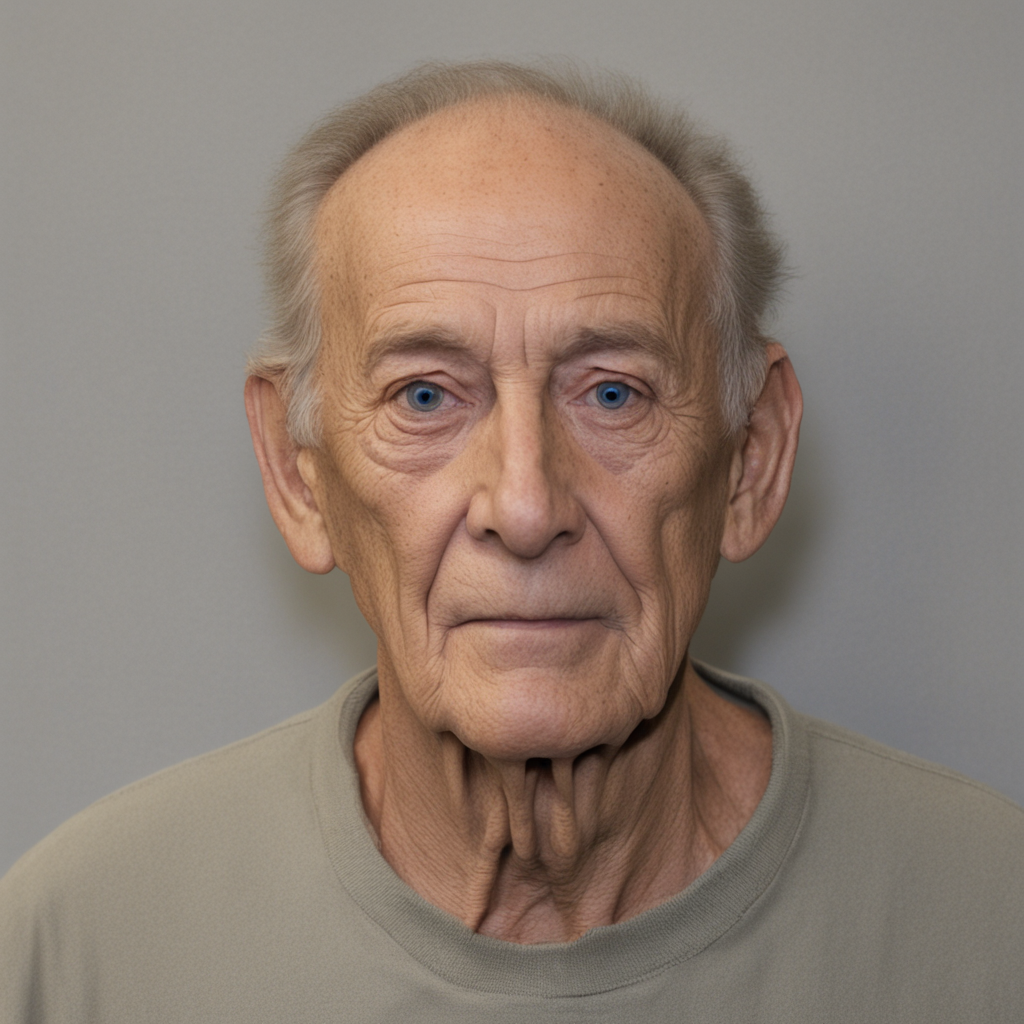

In [11]:
import os

# Specify the full path where you want to save the image
image_path = os.path.join(os.getcwd(), "generated_image.png")  # Saves to current working directory

# Save the image
image.save(image_path)

# Display the image
image.show()